<a href="https://colab.research.google.com/github/mdemarco1/CSC2053Final/blob/main/cnn_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_path = './drive/MyDrive/incabin_data/ar_images'

In [ ]:
def group_graphs(dataset_dir, group_size=6):
    images = []
    labels = []

    # Loop through each class folder (e.g., EXXX, LXXX)
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if os.path.isdir(class_path):
            for file_name in sorted(os.listdir(class_path)):
                if '_graph1.png' in file_name:  # Detect start of a trial (first graph)
                    trial_images = []
                    trial_prefix = file_name[:-11]  # e.g., EXXX1

                    # Collect all 6 graphs for this trial
                    for i in range(1, group_size + 1):
                        graph_file = f'{trial_prefix}_graph{i}.png'
                        graph_path = os.path.join(class_path, graph_file)

                        if os.path.exists(graph_path):
                            img = tf.io.read_file(graph_path)
                            img = tf.image.decode_png(img, channels=3)
                            img = tf.image.resize(img, [256, 256])
                            trial_images.append(img)

                    if len(trial_images) == group_size:  # Ensure all 6 graphs are present
                        images.append(tf.stack(trial_images))  # Stack 6 images for one trial
                        labels.append(class_name)  # Assign class label based on folder name

    return tf.data.Dataset.from_tensor_slices((images, labels))


In [ ]:
grouped_dataset = group_graphs(data_path)

In [ ]:
for grouped_images, label in grouped_dataset.take(1):
  print(grouped_images.shape)
  print(label)

(6, 256, 256, 3)
tf.Tensor(b'XXXL', shape=(), dtype=string)


In [ ]:
class_mapping = {'EXXX': 0, 'LXXX': 1, 'XEXX': 2, 'XLXX': 3, 'XXEX': 4, 'XXLX': 5, 'XXXE': 6, 'XXXL': 7}

# Create a lookup table for the class names
keys_tensor = tf.constant(list(class_mapping.keys()))  # Class names (strings)
vals_tensor = tf.constant(list(class_mapping.values()))  # Corresponding integers

# Create the lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1  # Default value for unknown keys
)

# Function to map string labels to numeric labels using the lookup table
def map_labels(images, label):
    # Convert the class name (string) to a tensor
    label_tensor = tf.convert_to_tensor(label)

    # Use the lookup table to map the label string to a numeric label
    numeric_label = table.lookup(label_tensor)

    return images, numeric_label

# Apply the mapping to the dataset
numeric_dataset = grouped_dataset.map(map_labels)
# numeric_dataset = grouped_dataset.filter(filter_invalid_labels)
# Preview the dataset with numeric labels
for grouped_images, label in numeric_dataset.take(1):
    print(grouped_images.shape)  # (6, 256, 256, 3)
    print(label)                 # Numeric label (0-7)


(6, 256, 256, 3)
tf.Tensor(7, shape=(), dtype=int32)


In [ ]:
dataset_size = numeric_dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)

# Shuffle the dataset before splitting
numeric_dataset = numeric_dataset.shuffle(buffer_size=dataset_size)

# Split into train and test datasets
train_dataset = numeric_dataset.take(train_size)
test_dataset = numeric_dataset.skip(train_size)

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
# CNN model
input_layer = tf.keras.layers.Input(shape=(6, 256, 256, 3))  # 6 images, each 256x256x3
conv_layers = []

# Apply Conv2D separately to each of the 6 graphs
for i in range(6):
    conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer[:, i])
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    conv_layers.append(pool)

# Concatenate the outputs from all 6 graphs
concatenated = tf.keras.layers.Concatenate(axis=1)(conv_layers)

# Flatten and feed into dense layers
flat = tf.keras.layers.Flatten()(concatenated)
dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
output_layer = tf.keras.layers.Dense(8, activation='softmax')(dense1)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.1593 - loss: 20336.5566 - val_accuracy: 0.1250 - val_loss: 101074.5391
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - accuracy: 0.1912 - loss: 87310.7344 - val_accuracy: 0.1250 - val_loss: 75019.0391
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.1919 - loss: 97113.5859 - val_accuracy: 0.3750 - val_loss: 45682.1016
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.2668 - loss: 44048.0977 - val_accuracy: 0.3125 - val_loss: 19024.7441
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 0.3088 - loss: 32875.1328 - val_accuracy: 0.4375 - val_loss: 17278.4453
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 0.5423 - loss: 14884.4746 - val_accuracy: 0.8125 - val_loss: 2354.9265
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - accuracy: 0.7769 - loss: 3676.0244 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 1

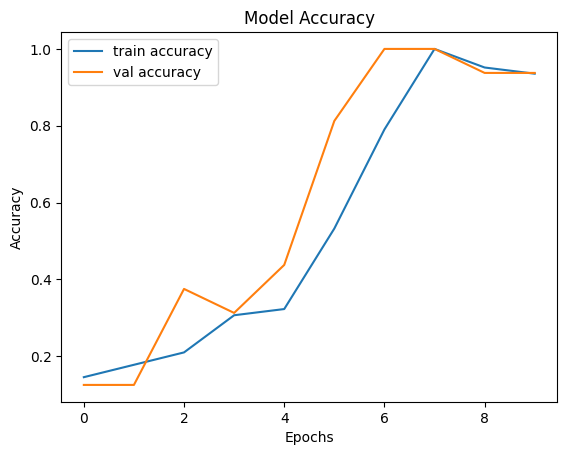

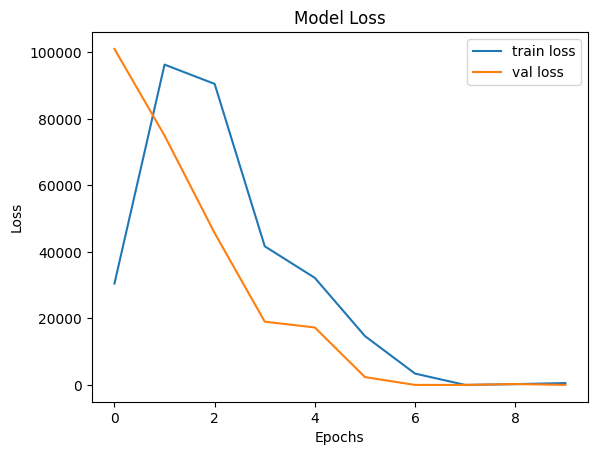

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

['.config', 'drive', 'sample_data']

In [ ]:
model.save('./drive/MyDrive/incabin_data/first_cnn.keras')

Testing the saved model with apparent accuracy 1 and loss 0

In [ ]:
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))  # Load and resize image
    image = tf.keras.preprocessing.image.img_to_array(image)  # Convert to array
    image = image / 255.0  # Normalize to [0,1]
    return image

In [ ]:
model = keras.models.load_model('./drive/MyDrive/incabin_data/first_cnn.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_map = {
    0: '1 person entered the drivers seat',
    1: '1 person exited the drivers seat',
    2: '1 person entered the passenger seat',
    3: '1 person exited the passenger seat',
    4: '1 person entered the back right seat',
    5: '1 person exited the back right seat',
    6: '1 person entered the back left seat',
    7: '1 person exited the back left seat'
}

# graph_paths = [
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph1.png',
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph2.png',
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph3.png',
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph4.png',
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph5.png',
#     './drive/MyDrive/incabin_data/ar_images/XXXE/XXXE6_graph6.png'
# ]

# graph_paths = [
#     './drive/MyDrive/incabin_data/test_enter/test_graph1.png',
#     './drive/MyDrive/incabin_data/test_enter/test_graph2.png',
#     './drive/MyDrive/incabin_data/test_enter/test_graph3.png',
#     './drive/MyDrive/incabin_data/test_enter/test_graph4.png',
#     './drive/MyDrive/incabin_data/test_enter/test_graph5.png',
#     './drive/MyDrive/incabin_data/test_enter/test_graph6.png'
# ]

graph_paths = [
    './drive/MyDrive/incabin_data/test_1p/test_graph1.png',
    './drive/MyDrive/incabin_data/test_1p/test_graph2.png',
    './drive/MyDrive/incabin_data/test_1p/test_graph3.png',
    './drive/MyDrive/incabin_data/test_1p/test_graph4.png',
    './drive/MyDrive/incabin_data/test_1p/test_graph5.png',
    './drive/MyDrive/incabin_data/test_1p/test_graph6.png'
]

graphs = np.stack([preprocess_image(path) for path in graph_paths])

# Add batch dimension since the model expects (batch_size, 6, 256, 256, 3)
graphs = np.expand_dims(graphs, axis=0)

predictions = model.predict(graphs)

predict_class = np.argmax(predictions, axis=1)

print(f'{output_map[predict_class[0]]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1 person entered the drivers seat
